In [1]:
import warnings
warnings.filterwarnings("ignore")

### Importing Libraries

In [2]:
import spacy
import logging
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from TorchCRF import CRF

### Load Dataset

In [3]:
# Function to load the datatset
def load_dataset(file_path):
    sentences = []
    labels = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        sentence = []
        
        for line in lines:
            line = line.strip() # Remove leading/trailing whitespaces
            if line:
                if not line.startswith('ARG1') and not line.startswith('ARG2') and not line.startswith('REL') and not line.startswith('LOC') and not line.startswith('TIME') and not line.startswith('NONE'):
                    sentence = line
                else:
                    current_label = line
                    sentences.append(sentence)
                    labels.append(current_label)
                    
    return sentences, labels

In [4]:
# Load the dataset into a pandas dataframe
sentences, labels = load_dataset('./Dataset/original_cleaned')
df = pd.DataFrame({
    'Sentence': sentences,
    'Labels': labels
})

In [5]:
df.shape

(180517, 2)

In [6]:
df

,Sentence,Labels
0,Simon is quoted as saying `` if you 'd ever se...,ARG1 REL REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG...
1,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...
2,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE ARG1 REL TI...
3,Simon is quoted as saying `` if you 'd ever se...,ARG1 NONE NONE REL REL NONE NONE NONE NONE NON...
4,The couple had no children .,ARG1 ARG1 REL ARG2 ARG2 NONE
...,...,...
180512,Afterwards Ong wrote : `` Hands holding Tai ch...,NONE NONE NONE NONE NONE ARG1 REL ARG2 ARG2 AR...
180513,Afterwards Ong wrote : `` Hands holding Tai ch...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...
180514,This was the time when Yang Luchan made the Ch...,ARG1 REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 AR...
180515,This was the time when Yang Luchan made the Ch...,NONE NONE TIME TIME NONE ARG1 ARG1 REL ARG2 AR...


In [7]:
df = df[:4500]

### Tokenize Sentences

In [8]:
def remerge_sent(sent):
    # merges tokens which are not separated by white-space
    # does this recursively until no further changes
    changed = True
    while changed:
        changed = False
        i = 0
        while i < sent.__len__() - 1:
            tok = sent[i]
            if not tok.whitespace_:
                ntok = sent[i + 1]
                # in-place operation.
                with sent.retokenize() as retokenizer:
                    retokenizer.merge(sent[i: i + 2])
                changed = True
            i += 1
    return sent

In [9]:
# Tokenize sentences using spacy
nlp = spacy.load('en_core_web_sm')

In [10]:
def check_token_label_length(row):
    doc = nlp(row['Sentence'])
    spacy_sentence = remerge_sent(doc)
    tokens = [token.text for token in spacy_sentence]
    labels = row['Labels'].split()

    is_match = len(tokens) == len(labels)
    return is_match, len(tokens), len(labels), tokens

In [11]:
df[['Token_Label_Match', 'Num_Tokens', 'Num_Labels', 'Tokens']] = df.apply(check_token_label_length, axis=1, result_type="expand")

In [12]:
df.head()

,Sentence,Labels,Token_Label_Match,Num_Tokens,Num_Labels,Tokens
0,Simon is quoted as saying `` if you 'd ever se...,ARG1 REL REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
1,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
2,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE ARG1 REL TI...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
3,Simon is quoted as saying `` if you 'd ever se...,ARG1 NONE NONE REL REL NONE NONE NONE NONE NON...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
4,The couple had no children .,ARG1 ARG1 REL ARG2 ARG2 NONE,True,6,6,"[The, couple, had, no, children, .]"


In [13]:
# Checking rows where token and label count don't match
mismatched_rows = df[df['Token_Label_Match'] == False]
print(mismatched_rows)

Empty DataFrame
Columns: [Sentence, Labels, Token_Label_Match, Num_Tokens, Num_Labels, Tokens]
Index: []


### Generate BERT Embeddings

In [14]:
# Load the pre-trained BERT tokenizer and model
# Load the fast version of the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model = AutoModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

In [15]:
# Retrieves BERT embeddings for a list of tokens using a fast tokenizer, enabling accurate aggregation of subword embeddings into their original token representations.
def get_bert_embeddings(tokens):
    inputs = tokenizer(tokens, return_tensors='pt', is_split_into_words=True, padding=False, truncation=True)

    # Get BERT embeddings from the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the embeddings for each subword
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)
    # Get word_ids to align subword tokens with the original tokens
    word_ids = inputs.word_ids()

    # Aggregate subword embeddings back to their original tokens
    aggregated_embeddings = []
    current_token_embeddings = []

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if len(current_token_embeddings) > 0 and word_id != word_ids[idx - 1]:
            aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))
            current_token_embeddings = []
        current_token_embeddings.append(token_embeddings[idx])
    
    if len(current_token_embeddings) > 0:
        aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))

    return torch.stack(aggregated_embeddings)

In [16]:
# Function to generate BERT embeddings for dataFrame
def generate_embeddings(df):
    embeddings_list = []
    for _, row in df.iterrows():
        tokenized_sentence = row['Tokens']
        embeddings = get_bert_embeddings(tokenized_sentence)
        embeddings_list.append(embeddings)
    return embeddings_list

In [17]:
embeddings_list = generate_embeddings(df)

In [18]:
# Checking the length of longest sentence embedding
max_len = max(embedding.shape[0] for embedding in embeddings_list)
print(f"The length of the longest embedding is: {max_len}")

The length of the longest embedding is: 133


In [19]:
# Pad the embeddings to ensure uniformity across dataset as model will be trained in batches
padded_embeddings = pad_sequence(embeddings_list, batch_first=True)
df['Embeddings'] = [padded_embeddings[i] for i in range(padded_embeddings.shape[0])]
print(padded_embeddings.shape)

torch.Size([4500, 133, 768])


### Encoding the Labels

In [20]:
# Encode the labels
label_encoder = LabelEncoder()
labels_list = ['ARG1', 'ARG2', 'REL', 'TIME', 'LOC', 'NONE', 'PADDING'] # Adding a new label for padding
label_encoder.fit(labels_list)

df['Encoded_Labels'] = df['Labels'].apply(lambda x: label_encoder.transform(x.split()))

In [21]:
# Encoded labels are of different lengths
df['Encoded_Labels']

0       [0, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
2       [3, 3, 3, 3, 3, 3, 3, 0, 5, 6, 5, 1, 3, 3, 3, ...
3       [0, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...
4                                      [0, 0, 5, 1, 1, 3]
                              ...                        
4495    [0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, ...
4496    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
4497    [3, 3, 0, 0, 0, 0, 3, 3, 5, 1, 1, 1, 1, 3, 3, ...
4498    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, ...
4499    [0, 0, 0, 5, 5, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, ...
Name: Encoded_Labels, Length: 4500, dtype: object

In [22]:
# Function to pad labels to max length
def pad_labels(labels, max_len, padding_label):
    # Initialize a tensor with the padding label (assuming integer encoding)
    padded_labels = torch.full((max_len,), padding_label, dtype=torch.long)
    padded_labels[:len(labels)] = torch.tensor(labels, dtype=torch.long)
    return padded_labels

In [23]:
padding_label = label_encoder.transform(['PADDING'])[0]
max_len = max(len(label) for label in df['Encoded_Labels'])

padded_labels = [pad_labels(label, max_len, padding_label) for label in df['Encoded_Labels']]
df['Padded_Labels'] = padded_labels

In [24]:
df['Padded_Label_Length'] = df['Padded_Labels'].apply(len)
print(df[['Padded_Labels', 'Padded_Label_Length']])

                                          Padded_Labels  Padded_Label_Length
0     [tensor(0), tensor(5), tensor(5), tensor(1), t...                  133
1     [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
2     [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
3     [tensor(0), tensor(3), tensor(3), tensor(5), t...                  133
4     [tensor(0), tensor(0), tensor(5), tensor(1), t...                  133
...                                                 ...                  ...
4495  [tensor(0), tensor(0), tensor(0), tensor(0), t...                  133
4496  [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
4497  [tensor(3), tensor(3), tensor(0), tensor(0), t...                  133
4498  [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
4499  [tensor(0), tensor(0), tensor(0), tensor(5), t...                  133

[4500 rows x 2 columns]


### Train Validation Split

In [25]:
# Split the data into training and validation sets
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
    df['Embeddings'].tolist(),  
    df['Padded_Labels'].tolist(),
    test_size=0.2,
    random_state=42
)

In [26]:
train_dataset = TensorDataset(torch.stack(train_embeddings), torch.stack(train_labels))
val_dataset = TensorDataset(torch.stack(val_embeddings), torch.stack(val_labels))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

In [27]:
label_to_idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}
label_to_idx

{'ARG1': 0, 'ARG2': 1, 'LOC': 2, 'NONE': 3, 'PADDING': 4, 'REL': 5, 'TIME': 6}

In [28]:
train_dataset[0]

(tensor([[ 0.1327,  0.5483, -0.3385,  ...,  0.0473,  0.7276,  0.3123],
         [-0.1138,  0.3154,  0.3915,  ...,  0.2379,  0.4851,  0.4113],
         [ 0.5261,  0.3337,  0.3916,  ..., -0.0206,  0.3245,  0.2162],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([3, 3, 3, 3, 0, 5, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

### BiLSTM CRF Model

In [29]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM_CRF, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True, num_layers=2)
        
        # Additional FC layers for more complex feature extraction
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

        self.activation = nn.ReLU()  # Activation function
        self.dropout = nn.Dropout(0.5)  # Regularization
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        # CRF layer
        self.crf = CRF(output_dim, batch_first=True)

    def forward(self, inputs, tags=None, mask=None):
        lstm_out, _ = self.lstm(inputs)
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.batch_norm(lstm_out.transpose(1, 2)).transpose(1, 2)

        # Use more non-linear transformations before passing to CRF
        fc_output = self.activation(self.fc1(lstm_out))
        fc_output = self.activation(self.fc2(fc_output))
        emissions = self.fc3(fc_output)  # Final emission scores for CRF

        if tags is not None:  # If tags are provided, calculate the loss
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        
        # If tags are not provided, return the predicted tags
        return self.crf.decode(emissions, mask=mask)

# Model parameters
input_dim = 768  # BERT Embedding size
hidden_dim = 256
output_dim = len(labels_list)

model = BiLSTM_CRF(input_dim, hidden_dim, output_dim)


### Training Loop

In [32]:
lr = 0.001
num_epochs = 100

loss_fn = nn.CrossEntropyLoss(ignore_index=label_to_idx['PADDING'])
optimizer = optim.Adam(model.parameters(), lr=lr)

# List to store the average loss per epoch
epoch_losses = []

# Training the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        inputs, labels = batch

        # Create mask for valid tokens (non-padding)
        # Will set valid labels to True and padding labels to False
        mask = labels.ne(label_to_idx['PADDING'])  # Mask of shape [batch_size, seq_len]

        # Forward pass through the model to get logits
        loss = model(inputs, tags=labels, mask=mask)  #Shape: [batch_size, max_seq_len, num_classes]
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)  # Store the average loss for this epoch

    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

Epoch 1/100, Loss: 6.897465984026591
Epoch 2/100, Loss: 6.282835351096259
Epoch 3/100, Loss: 5.978765606880188
Epoch 4/100, Loss: 5.777031991216871
Epoch 5/100, Loss: 5.623313758108351
Epoch 6/100, Loss: 5.436686568790012
Epoch 7/100, Loss: 5.359260472986433
Epoch 8/100, Loss: 5.256540192498101
Epoch 9/100, Loss: 5.115243924988641
Epoch 10/100, Loss: 4.874767555130853
Epoch 11/100, Loss: 4.7804322772555885
Epoch 12/100, Loss: 4.71659857696957
Epoch 13/100, Loss: 4.6763523949517145
Epoch 14/100, Loss: 4.468268394470215
Epoch 15/100, Loss: 4.342884414725834
Epoch 16/100, Loss: 4.273258090019226
Epoch 17/100, Loss: 4.238259063826667
Epoch 18/100, Loss: 4.142534057299296
Epoch 19/100, Loss: 4.175094101164076
Epoch 20/100, Loss: 4.015753759278192
Epoch 21/100, Loss: 3.9966424107551575
Epoch 22/100, Loss: 4.040042618910472
Epoch 23/100, Loss: 3.8765234880977206
Epoch 24/100, Loss: 3.734935720761617
Epoch 25/100, Loss: 3.654985401365492
Epoch 26/100, Loss: 3.6388171778784857
Epoch 27/100, Los

### Plotting the Training Loss

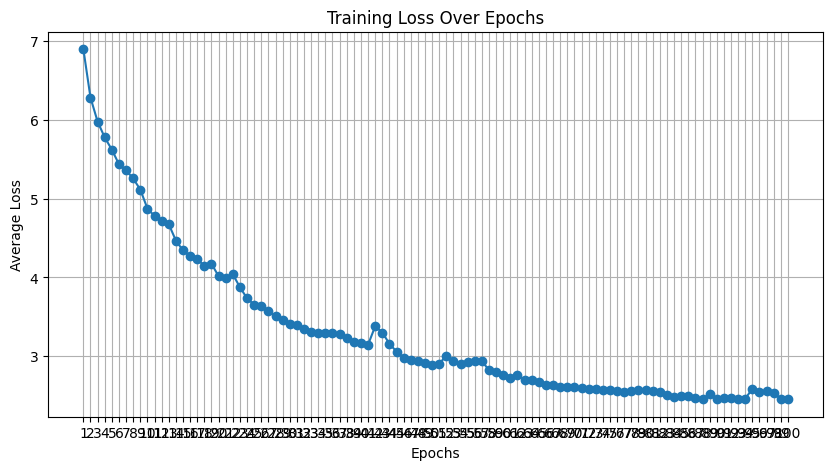

In [35]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid()
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to each epoch
plt.show()

### Evaluating on Validation Data

In [36]:
def evaluate_bilstm_crf(model, val_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Create mask for valid tokens (non-padding)
            mask = labels.ne(label_to_idx['PADDING'])  # Mask of shape [batch_size, seq_len]

            # Forward pass through the model to get predicted tags (for CRF)
            predicted_tags = model(inputs)

            # Since predicted_tags is a list of lists, convert it to a tensor for indexing
            predicted_tags = torch.tensor(predicted_tags, dtype=torch.long, device=labels.device)

            # Calculate loss only for valid tokens (masking padding labels)
            loss = model(inputs, tags=labels)  # This returns the loss with CRF
            total_loss += loss.item()

            # Mask needs to be applied on predicted_tags and labels
            correct += (predicted_tags[mask] == labels[mask]).sum().item()  # Compare valid tokens
            total += mask.sum().item()  # Count only valid tokens

    avg_loss = total_loss / len(val_loader)  # Average loss per batch
    accuracy = correct / total if total > 0 else 0  # Avoid division by zero
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

In [37]:
avg_val_loss, val_accuracy = evaluate_bilstm_crf(model, val_loader)

Validation Loss: 1087.2895, Validation Accuracy: 0.5908


### Logging the Text Output

In [38]:
# Set up logging
logging.basicConfig(
    filename='bilstm_crf_val_predictions.log', 
    level=logging.INFO, 
    format='%(asctime)s - %(message)s',
)

def evaluate_bilstm_crf_with_text_output(model, embeddings, labels):
    model.eval()
    with torch.no_grad():
        for emb, true_labels in zip(embeddings, labels):
            # Add batch dimension
            emb = emb.unsqueeze(0)  # Shape: [1, seq_length, input_dim]
            true_labels = true_labels.unsqueeze(0)  # Shape: [1, seq_length]

            # Forward pass through the model to get predictions
            # Ensure the model returns the predicted tags from CRF
            predicted_tags = model(emb)
            
            if isinstance(predicted_tags, list):
                predicted_indices = predicted_tags[0]
            else:
                predicted_indices = predicted_tags

            # Convert predicted and true label indices to label names
            predicted_labels = label_encoder.inverse_transform(predicted_indices)
            true_labels_text = label_encoder.inverse_transform(true_labels.squeeze(0).cpu().numpy())

            # Log the predicted and true labels
            logging.info(f"Predicted Labels: {predicted_labels}")
            logging.info(f"True Labels:      {true_labels_text}")
            logging.info("-" * 50)

evaluate_bilstm_crf_with_text_output(model, val_embeddings, val_labels)

### CaRB Metric

In [39]:
def load_test_dataset(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = file.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    df_test = pd.DataFrame(sentences, columns=['Sentence'])
    return df_test

df_test = load_test_dataset('./Dataset/test.txt')

In [40]:
df_test

,Sentence
0,32.7 % of all households were made up of indiv...
1,A CEN forms an important but small part of a L...
2,"A Democrat , he became the youngest mayor in P..."
3,A cafeteria is also located on the sixth floor...
4,A casting director at the time told Scott that...
...,...
636,`` Now everything '' -- such as program tradin...
637,`` The bottom line is that if we can get that ...
638,`` The only people who are flying are those wh...
639,`` To allow this massive level of unfettered f...


In [41]:
def generate_test_token(row):
    # Process the sentence with SpaCy
    doc = nlp(row['Sentence'])
    spacy_sentence = remerge_sent(doc)
    tokens = [token.text for token in spacy_sentence]

    return tokens

In [42]:
df_test['Tokens'] = df_test.apply(generate_test_token, axis=1)

In [43]:
df_test

,Sentence,Tokens
0,32.7 % of all households were made up of indiv...,"[32.7, %, of, all, households, were, made, up,..."
1,A CEN forms an important but small part of a L...,"[A, CEN, forms, an, important, but, small, par..."
2,"A Democrat , he became the youngest mayor in P...","[A, Democrat, ,, he, became, the, youngest, ma..."
3,A cafeteria is also located on the sixth floor...,"[A, cafeteria, is, also, located, on, the, six..."
4,A casting director at the time told Scott that...,"[A, casting, director, at, the, time, told, Sc..."
...,...,...
636,`` Now everything '' -- such as program tradin...,"[``, Now, everything, '', --, such, as, progra..."
637,`` The bottom line is that if we can get that ...,"[``, The, bottom, line, is, that, if, we, can,..."
638,`` The only people who are flying are those wh...,"[``, The, only, people, who, are, flying, are,..."
639,`` To allow this massive level of unfettered f...,"[``, To, allow, this, massive, level, of, unfe..."


In [44]:
embeddings_list_test = generate_embeddings(df_test)

In [45]:
# Pad the embeddings to ensure uniformity across dataset as model will be trained in batches
padded_embeddings_test = pad_sequence(embeddings_list_test, batch_first=True)
df_test['Embeddings'] = [padded_embeddings_test[i] for i in range(padded_embeddings_test.shape[0])]
print(padded_embeddings_test.shape)

torch.Size([641, 63, 768])


### Generate Test Output

In [46]:
# Create the reverse mapping from index to label
idx_to_label = {v: k for k, v in label_to_idx.items()}

### Approach 1: Enforce a Strict Pattern on the Extractions

In [47]:
def generate_extractions_bilstm_crf_strict(model, padded_embeddings, df_test):
    model.eval()
    
    with torch.no_grad():
        predicted_tags = model(padded_embeddings)
        predicted_tags = torch.tensor(predicted_tags, dtype=torch.long, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    results = []
    skipped_count = 0
    
    for i, row in df_test.iterrows():
        sentence = row['Sentence']
        tokens = row['Tokens']
        n = len(tokens) 

        predicted_labels = predicted_tags[i][:n]
        valid_tokens = tokens[:len(predicted_labels)]
        sentence_results = []
        
        current_rel = []
        current_time = []
        current_loc = []
        arg1_list, arg2_list = [], []
        arg1_pos, arg2_pos, rel_pos = -1, -1, -1
        
        found_rel = False  
        found_arg1 = False 
        found_arg2 = False  
        found_time = False 
        found_loc = False

        for token_index in range(len(predicted_labels)):
            if token_index >= len(valid_tokens):
                print(f"Warning: token_index {token_index} is out of bounds for valid_tokens.")
                break
            
            predicted_class = predicted_labels[token_index]
            label = idx_to_label[predicted_class.item()] 
            token = valid_tokens[token_index]
            
            if label == 'REL':
                found_rel = True  
                if current_rel and token_index == current_rel[-1][-1] + 1:
                    current_rel[-1][0].append(token)  # Continue building multi-word relation
                    current_rel[-1][-1] = token_index
                else:
                    current_rel.append([[token], token_index])  # Start a new relation phrase
                rel_pos = token_index

            elif label == 'ARG1':
                found_arg1 = True  
                arg1_list.append(token)
                arg1_pos = token_index

            elif label == 'ARG2':
                found_arg2 = True  
                arg2_list.append(token)
                arg2_pos = token_index

            elif label == 'TIME':
                found_time = True 
                if current_time and token_index == current_time[-1][-1] + 1:
                    current_time[-1][0].append(token)  # Continue building multi-token time phrase
                    current_time[-1][-1] = token_index
                else:
                    current_time.append([[token], token_index])  # Start a new time phrase

            elif label == 'LOC':
                found_loc = True  
                if current_loc and token_index == current_loc[-1][-1] + 1:
                    current_loc[-1][0].append(token)  # Continue building multi-token location phrase
                    current_loc[-1][-1] = token_index
                else:
                    current_loc.append([[token], token_index])  # Start a new location phrase

        if current_rel:
            rel = ' '.join([' '.join(r[0]) for r in current_rel])  # Multi-word relation
            time_str = ' '.join([' '.join(t[0]) for t in current_time]) if current_time else ''
            loc_str = ' '.join([' '.join(l[0]) for l in current_loc]) if current_loc else ''
            
            # Standard pattern: ARG1 before REL, ARG2 after REL
            if found_arg1 and found_arg2 and arg1_pos < rel_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Inverted pattern: ARG2 before REL, ARG1 after REL
            if found_arg1 and found_arg2 and arg2_pos < rel_pos < arg1_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg2_list)}\t{' '.join(arg1_list)}\t{time_str}\t{loc_str}")
            
            # Both ARG1 and ARG2 before REL
            if found_arg1 and found_arg2 and arg1_pos < arg2_pos < rel_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Both ARG1 and ARG2 after REL
            if found_arg1 and found_arg2 and rel_pos < arg1_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Loosened: Capture relations with only ARG1 or ARG2
            if found_arg1 and not found_arg2:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t\t{time_str}\t{loc_str}")
            if found_arg2 and not found_arg1:
                sentence_results.append(f"{sentence}\t1\t{rel}\t\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
        
        # Handle case where no relations or arguments are found, but time or location might be present
        if not found_rel and not found_arg1 and not found_arg2:
            if found_time or found_loc:
                # If time or location found, include in results even without relations or arguments
                time_str = ' '.join([' '.join(t[0]) for t in current_time]) if current_time else ''
                loc_str = ' '.join([' '.join(l[0]) for l in current_loc]) if current_loc else ''
                sentence_results.append(f"{sentence}\t0.5\t\t\t{time_str}\t{loc_str}")
            else:
                skipped_count += 1  # Increment skipped count
                print(f"Skipped sentence {i}: {sentence} with predicted labels: {predicted_labels}")
        
        results.extend(sentence_results)

    return results, skipped_count  # Return both results and skipped count

In [48]:
extractions, skipped_count = generate_extractions_bilstm_crf_strict(model, padded_embeddings_test, df_test)
print(f"Total skipped sentences: {skipped_count}")

# Write output extractions to a tab separated file
with open('../CaRB/system_outputs/test/extractions_strict.txt', 'w') as f:
    for extraction in extractions:
        f.write(extraction + '\n')

print("Test Extraction Strict file has been created.")

Skipped sentence 4: A casting director at the time told Scott that he had wished that he 'd met him a week before ; he was casting for the `` G.I. Joe '' cartoon . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 5: A common name , logo , and programming schedule followed in 1982 , with the establishment of the `` TV8 '' network between the three stations , changed to the `` Southern Cross Network '' seven years later . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 10: A partial list of turbomachinery that may use one or more centrifugal compressors within the machine are listed here . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 13: According to Hofmann , while still a teenage coin collector , 

### Apporach 2: Assign Confidence Value to Extractions

In [49]:
def extract_confidence_features(sentence, rel, arg1, arg2, tokens):
    features = {}

    # Check if (x, r, y) covers all words in the sentence
    features['covers_all_words'] = len(arg1.split()) + len(rel.split()) + len(arg2.split()) == len(tokens)

    # Check for specific prepositions in relation
    last_token_rel = rel.split()[-1] if rel.split() else ''
    features['last_prep_for'] = last_token_rel == 'for'
    features['last_prep_on'] = last_token_rel == 'on'
    features['last_prep_of'] = last_token_rel == 'of'
    features['last_prep_to'] = last_token_rel == 'to'
    features['last_prep_in'] = last_token_rel == 'in'

    # Sentence length
    features['short_sentence'] = len(tokens) <= 10
    features['medium_sentence'] = 10 < len(tokens) <= 20
    features['long_sentence'] = len(tokens) > 20

    # Check for WH-word to the left of the relation
    wh_words = ['who', 'what', 'where', 'when', 'why', 'how']
    features['wh_word_left'] = any(word in tokens[:tokens.index(rel.split()[0])] for word in wh_words if rel)

    # Check if r matches specific patterns (e.g., VW*P)
    vw_p_pattern = True  # Implement specific pattern-matching logic based on your extraction rules
    v_pattern = True  # Implement specific pattern-matching logic based on your extraction rules
    features['r_matches_vw_p'] = vw_p_pattern
    features['r_matches_v'] = v_pattern

    # Check if sentence starts with ARG1
    features['sentence_starts_with_x'] = sentence.startswith(arg1)

    # Proper noun checks for ARG1 and ARG2 (a more advanced check might use POS tagging)
    features['arg1_is_proper_noun'] = arg1.istitle()
    features['arg2_is_proper_noun'] = arg2.istitle()

    return features

In [50]:
def calculate_confidence(features):
    # Feature weights with adjustments to boost confidence for correct predictions
    weights = {
        'covers_all_words': 2.5,  # Further increased weight for covering all words
        'last_prep_for': 1.0,
        'last_prep_on': 0.9,
        'last_prep_of': 0.8,
        'short_sentence': 0.7,
        'wh_word_left': 0.6,
        'r_matches_vw_p': 0.7,
        'last_prep_to': 0.6,
        'last_prep_in': 0.5,
        'medium_sentence': 0.5,
        'sentence_starts_with_x': 0.5,
        'arg2_is_proper_noun': 0.4,
        'arg1_is_proper_noun': 0.2,
        'long_sentence': -0.3,
        'r_matches_v': -0.4,
        'np_left_of_x': -0.5,
        'prep_left_of_x': -0.5,
        'np_right_of_y': -0.7,
        'coord_conj_left_of_r': -0.9,
        'verb_in_rel': 0.6,  
        'valid_structure': 0.8  
    }

    # Compute the weighted sum of the feature values
    confidence_score = sum(weights[key] * features[key] for key in features if key in weights)

    bias = 3.0  
    confidence_score += bias

    # Normalize the confidence score to be between 0 and 1
    min_score = 0  
    max_score = 10 
    normalized_score = (confidence_score - min_score) / (max_score - min_score) * 1

    return max(0, min(normalized_score, 1))

In [51]:
def generate_extractions_bilstm_crf_with_confidence(model, padded_embeddings, df_test):
    model.eval()
    
    with torch.no_grad():
        predicted_tags = model(padded_embeddings)
        predicted_tags = torch.tensor(predicted_tags, dtype=torch.long, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    results = []
    skipped_count = 0
    
    for i, row in df_test.iterrows():
        sentence = row['Sentence']
        tokens = row['Tokens']
        n = len(tokens) 

        predicted_labels = predicted_tags[i][:n]
        valid_tokens = tokens[:len(predicted_labels)]
        sentence_results = []
        
        current_rel = []
        current_time = []
        current_loc = []
        arg1_list, arg2_list = [], []
        arg1_pos, arg2_pos, rel_pos = -1, -1, -1
        
        found_rel = False 
        found_arg1 = False  
        found_arg2 = False  
        found_time = False 
        found_loc = False 

        for token_index in range(len(predicted_labels)):
            if token_index >= len(valid_tokens):
                print(f"Warning: token_index {token_index} is out of bounds for valid_tokens.")
                break
            
            predicted_class = predicted_labels[token_index]
            label = idx_to_label[predicted_class.item()] 
            token = valid_tokens[token_index]
            
            if label == 'REL':
                found_rel = True
                if current_rel and token_index == current_rel[-1][-1] + 1:
                    current_rel[-1][0].append(token)
                    current_rel[-1][-1] = token_index
                else:
                    current_rel.append([[token], token_index])
                rel_pos = token_index

            elif label == 'ARG1':
                found_arg1 = True
                arg1_list.append(token)
                arg1_pos = token_index

            elif label == 'ARG2':
                found_arg2 = True
                arg2_list.append(token)
                arg2_pos = token_index

            elif label == 'TIME':
                found_time = True
                if current_time and token_index == current_time[-1][-1] + 1:
                    current_time[-1][0].append(token)
                    current_time[-1][-1] = token_index
                else:
                    current_time.append([[token], token_index])

            elif label == 'LOC':
                found_loc = True
                if current_loc and token_index == current_loc[-1][-1] + 1:
                    current_loc[-1][0].append(token)
                    current_loc[-1][-1] = token_index
                else:
                    current_loc.append([[token], token_index])

        if current_rel:
            rel = ' '.join([' '.join(r[0]) for r in current_rel])
            time_str = ' '.join([' '.join(t[0]) for t in current_time]) if current_time else ''
            loc_str = ' '.join([' '.join(l[0]) for l in current_loc]) if current_loc else ''

            # Extract confidence features
            features = extract_confidence_features(sentence, rel, ' '.join(arg1_list), ' '.join(arg2_list), tokens)
            confidence_score = calculate_confidence(features)  # Get confidence score for each extraction
            
            # Standard pattern: ARG1 before REL, ARG2 after REL
            if found_arg1 and found_arg2 and arg1_pos < rel_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Inverted pattern: ARG2 before REL, ARG1 after REL
            if found_arg1 and found_arg2 and arg2_pos < rel_pos < arg1_pos:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t{' '.join(arg2_list)}\t{' '.join(arg1_list)}\t{time_str}\t{loc_str}")
            
            # Both ARG1 and ARG2 before REL
            if found_arg1 and found_arg2 and arg1_pos < arg2_pos < rel_pos:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Both ARG1 and ARG2 after REL
            if found_arg1 and found_arg2 and rel_pos < arg1_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
            
            # Loosened: Capture relations with only ARG1 or ARG2
            if found_arg1 and not found_arg2:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t{' '.join(arg1_list)}\t\t{time_str}\t{loc_str}")
            if found_arg2 and not found_arg1:
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t{rel}\t\t{' '.join(arg2_list)}\t{time_str}\t{loc_str}")
        
        # Handle case where no relations or arguments are found, but time or location might be present
        if not found_rel and not found_arg1 and not found_arg2:
            if found_time or found_loc:
                time_str = ' '.join([' '.join(t[0]) for t in current_time]) if current_time else ''
                loc_str = ' '.join([' '.join(l[0]) for l in current_loc]) if current_loc else ''
                sentence_results.append(f"{sentence}\t{confidence_score:.2f}\t\t\t{time_str}\t{loc_str}")
            else:
                skipped_count += 1
                print(f"Skipped sentence {i}: {sentence} with predicted labels: {predicted_labels}")
        
        results.extend(sentence_results)

    return results, skipped_count

In [52]:
extractions, skipped_count = generate_extractions_bilstm_crf_with_confidence(model, padded_embeddings_test, df_test)
print(f"Total skipped sentences: {skipped_count}")

# Write output extractions to a tab separated file
with open('../CaRB/system_outputs/test/extractions_confidence.txt', 'w') as f:
    for extraction in extractions:
        f.write(extraction + '\n')

print("Test Extraction Confidence file has been created.")

Skipped sentence 4: A casting director at the time told Scott that he had wished that he 'd met him a week before ; he was casting for the `` G.I. Joe '' cartoon . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 5: A common name , logo , and programming schedule followed in 1982 , with the establishment of the `` TV8 '' network between the three stations , changed to the `` Southern Cross Network '' seven years later . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 10: A partial list of turbomachinery that may use one or more centrifugal compressors within the machine are listed here . with predicted labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Skipped sentence 13: According to Hofmann , while still a teenage coin collector , 

### Error Analysis

In [53]:
def read_extractions(file_path):
    extractions = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():  # skip empty lines
                parts = line.split("\t")
                
                sentence = parts[0] 
                confidence = parts[1]  # Ignored confidence value
                rel = parts[2] 
                arg1 = parts[3]  
                arg2 = parts[4] 
        
                if sentence not in extractions:
                    extractions[sentence] = []
                extractions[sentence].append((rel, arg1, arg2))  # store relation, arg1, arg2 as tuple
                
    return extractions

In [54]:
def pos_tagging(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

In [55]:
# Helper functions for analyzing incorrect and missing extractions
def is_passive_voice(pos_tags):
    """ Check if the relation phrase is in passive voice """
    # Look for auxiliary verbs like 'was', 'is', etc., followed by a past participle verb (e.g., 'was eaten')
    aux_verb = None
    for i, (token, pos) in enumerate(pos_tags):
        if pos == 'AUX':
            aux_verb = True
        elif pos == 'VERB' and aux_verb:
            if token.endswith('ed') or token.endswith('en'):
                return True
        aux_verb = False  # Reset after verb
    return False


def verb_object_mismatch(relation_pos_tags, object_phrase):
    """ Check for verb-object mismatch """
    # Expanded list of verbs that typically do not take direct objects
    verbs_that_cannot_have_direct_objects = ["is", "seems", "become", "feel", "exist", "occur", "belong", "appear", "happen"]
    
    # Find verb in the relation and check if it can take a direct object
    for token, pos in relation_pos_tags:
        if pos == 'VERB' and token in verbs_that_cannot_have_direct_objects:
            return True
    return False


def is_non_contiguous(pos_tags):
    """ Check if POS tags for relation are non-contiguous (e.g., interrupted by punctuation or conjunctions) """
    gap_found = False
    for i, (token, pos) in enumerate(pos_tags):
        if pos == 'PUNCT' or pos == 'CCONJ':  # Punctuation or conjunctions indicate a gap
            gap_found = True
        if gap_found and pos == 'VERB':  # If a verb appears after the gap, relation is split
            return True
    return False


def is_imperative_verb(pos_tags):
    """ Check if the first word is a verb in imperative form """
    if len(pos_tags) > 0 and pos_tags[0][1] == 'VERB':
        # Use dependency parsing to check if this verb is the root (indicating an imperative sentence)
        doc = nlp(pos_tags[0][0])  # Parse the verb with spaCy
        for token in doc:
            if token.dep_ == 'ROOT' and token.tag_ in ['VB', 'VBP']:  # Imperative is often tagged as VB or VBP
                return True
    return False


def is_overspecified(pos_tags):
    """ Check if relation contains more than necessary details (e.g., prepositional phrases, modifiers) """
    overspecification_words = {'ADJ', 'DET', 'ADP', 'AUX'}
    unnecessary_words = []
    
    for tag in pos_tags:
        if tag[1] in overspecification_words:
            unnecessary_words.append(tag)

    # If more than 2 unnecessary words or a long relation, flag it as overspecified
    if len(unnecessary_words) > 2 or len(pos_tags) > 4:
        return True
    return False


def lexical_constraint_filter(relation):
    """ Check if a relation was filtered out due to lexical constraints (rare word, non-standard verb, etc.) """
    rare_words = ['defenestration', 'quixotic', 'anathema']
    filtered_phrases = ['rare_word', 'filtered_relation']
    
    return relation in rare_words or relation in filtered_phrases


def is_more_specific_relation(gold_extraction, predicted_extractions):
    """ Check if the predicted relation is a general form of the gold relation """
    gold_relation = gold_extraction[1]
    for pred in predicted_extractions:
        pred_relation = pred[1]
        # Check if the predicted relation is a generalization of the gold relation (subset of words)
        if gold_relation in pred_relation or pred_relation in gold_relation:
            return True
    return False


def calculate_percentage(errors, total):
    return {error: (count / total) * 100 for error, count in errors.items()}

In [56]:
def categorize_extraction_errors(gold_extractions, predicted_extractions):
    error_categories = Counter({
        "Correct relation, incorrect arguments": 0,
        "Correct relation, incorrect argument order": 0,
        "Correct relation, missing arguments": 0,
        "N-ary relation": 0,
        "Non-contiguous relation phrase": 0,
        "Imperative verb": 0,
        "Overspecified relation phrase": 0,
        "Other (POS/chunking errors)": 0
    })

    for sentence, gold_set in gold_extractions.items():
        if sentence in predicted_extractions:
            predicted_set = predicted_extractions[sentence]
            for gold in gold_set:
                if gold not in predicted_set:
                    # This handles incorrect extractions when the sentence is present
                    error_type = categorize_error_type(gold, predicted_set)
                    error_categories[error_type] += 1
        else:
            pass

    return error_categories


def categorize_error_type(gold_extraction, predicted_extractions):
    gold_relation = gold_extraction[1]
    gold_arg1 = gold_extraction[0]
    gold_arg2 = gold_extraction[2]
    
    for pred in predicted_extractions:
        pred_relation = pred[1]
        pred_arg1 = pred[0]
        pred_arg2 = pred[2]
        
        # Correct relation but incorrect arguments
        if pred_relation == gold_relation:
            # Check for incorrect argument order
            if pred_arg1 != gold_arg1 or pred_arg2 != gold_arg2:
                if pred_arg1 == gold_arg2 and pred_arg2 == gold_arg1:
                    return "Correct relation, incorrect argument order"
                if not pred_arg1 or not pred_arg2:
                    return "Correct relation, missing arguments"
                return "Correct relation, incorrect arguments"
        
        # N-ary relation: more than two arguments
        if len(pred) > 3:
            return "N-ary relation"
        
        # Non-contiguous relation phrase: check if relation is split
        pred_relation_pos = pos_tagging(pred_relation)
        if is_non_contiguous(pred_relation_pos):
            return "Non-contiguous relation phrase"
        
        # Imperative verb check: if relation starts with a verb in imperative mood
        if is_imperative_verb(pred_relation_pos):
            return "Imperative verb"
        
        # Overspecified relation phrase: relation contains unnecessary words
        if is_overspecified(pred_relation_pos):
            return "Overspecified relation phrase"
        
        # Check for passive voice
        if is_passive_voice(pred_relation_pos):
            return "Passive voice relation"
        
        # Check for verb-object mismatch
        if verb_object_mismatch(pred_relation_pos, pred_arg2):
            return "Verb-object mismatch"
    
    return "Other (POS/chunking errors)"

In [57]:
def categorize_missed_extractions(gold_extractions, predicted_extractions):
    missed_categories = Counter({
        "Could not identify correct arguments": 0,
        "Relation filtered out by lexical constraint": 0,
        "Identified a more specific relation": 0,
        "POS/chunking error": 0
    })

    for sentence, gold_set in gold_extractions.items():
        if sentence not in predicted_extractions:
            for gold in gold_set:
                if lexical_constraint_filter(gold[1]):
                    missed_categories["Relation filtered out by lexical constraint"] += 1
                elif is_more_specific_relation(gold, predicted_extractions.get(sentence, [])):
                    missed_categories["Identified a more specific relation"] += 1
                else:
                    missed_categories["Could not identify correct arguments"] += 1

    return missed_categories

In [58]:
# Compare and calculate error percentages
def analyze_extractions(gold_file, extraction_file):
    gold_extractions = read_extractions(gold_file)
    predicted_extractions = read_extractions(extraction_file)

    missed_errors = categorize_missed_extractions(gold_extractions, predicted_extractions)
    total_missed = sum(missed_errors.values())
    missed_percentages = calculate_percentage(missed_errors, total_missed)
    
    incorrect_errors = categorize_extraction_errors(gold_extractions, predicted_extractions)
    total_incorrect = sum(incorrect_errors.values())
    incorrect_percentages = calculate_percentage(incorrect_errors, total_incorrect)
    
    print("Missed Extractions:")
    for category, percentage in missed_percentages.items():
        print(f"{category}: {percentage:.2f}%")
    
    print("\nIncorrect Extractions:")
    for category, percentage in incorrect_percentages.items():
        print(f"{category}: {percentage:.2f}%")

In [59]:
analyze_extractions('./Dataset/test_gold.txt', './Dataset/extractions.txt')

Missed Extractions:
Could not identify correct arguments: 100.00%
Relation filtered out by lexical constraint: 0.00%
Identified a more specific relation: 0.00%
POS/chunking error: 0.00%

Incorrect Extractions:
Correct relation, incorrect arguments: 36.97%
Correct relation, incorrect argument order: 0.00%
Correct relation, missing arguments: 0.47%
N-ary relation: 0.00%
Non-contiguous relation phrase: 2.37%
Imperative verb: 0.00%
Overspecified relation phrase: 11.37%
Other (POS/chunking errors): 48.82%
